In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
import cv2
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Load the weights, graph and mean file:

In [2]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/media/jing/0C4F0EAC0C4F0EAC/video/data0520/end2end_regress_vgg_iter_12000.caffemodel'
DEPLOY_FILE = '/media/jing/0C4F0EAC0C4F0EAC/video/data0520/end2end_regression_deploy_vgg.prototxt'
MEAN_FILE = '/media/jing/0C4F0EAC0C4F0EAC/video/data0520/mean.npy'

mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 29.12508915  57.26958042  58.23305127]


### Load image and ground truth probability map:

In [19]:
idx = '8R090212'
#idx = '0015L035207'
#idx = '0015L035201'
#idx = '0015R023702'
#img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.jpg'
#prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.prob.jpg'
#img_name = '/home/jing/Pictures/'+idx+'.jpg'
img_name = '/media/jing/0C4F0EAC0C4F0EAC/video/data0520/patches2/'+idx+'.jpg'
prob_name = '/media/jing/0C4F0EAC0C4F0EAC/video/data0520/patches2/'+idx+'.prob.jpg'

image = caffe.io.load_image(img_name)
image = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
#plt.imshow(image)

### show the predicted probability map:

1.85689e-09 0.978204
0.978204


(-0.5, 49.5, 49.5, -0.5)

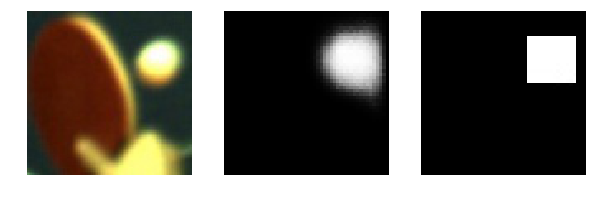

In [20]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

sodlt = net.blobs['sodlt_norm'].data[0][0]
print np.min(sodlt), np.max(sodlt)
print output['prob_max'][0]

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### show the bounding box computed from the probability map:

we can see that the bounding box is not accurate enough, thus a regression step is necessary.

[ 60.  14.  96.  48.]


(-0.5, 49.5, 49.5, -0.5)

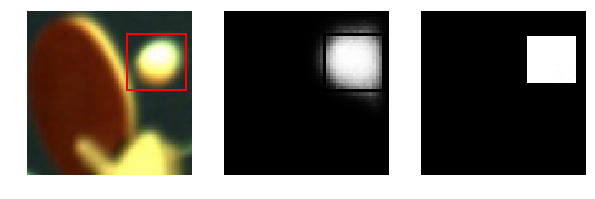

In [21]:
(x1,y1,x2,y2) = bbox = net.blobs['roi'].data[0]
print bbox*2

output_img = image.copy()
cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (1,0,0), 1)

plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(sodlt); plt.axis('off')

### Regression

after the regression step, the new bounding box contains the whole body of the object(ball), and less context.

[ 63.69252014  17.28496361  94.78059387  47.00609589]


(-0.5, 99.5, 99.5, -0.5)

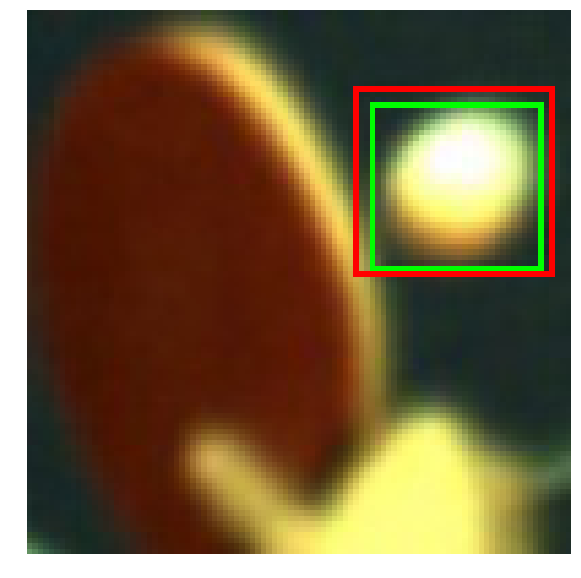

In [22]:
(x1,y1,x2,y2) = regress = output['bbox_pred'][0]
print regress*2

cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,1,0), 1)

#plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

#plt.subplot(1, 3, 3)
#prob = caffe.io.load_image(prob_name)
#plt.imshow(prob); plt.axis('off')

#plt.subplot(1, 3, 2)
#cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
#plt.imshow(sodlt); plt.axis('off')

### architecture of the regression model:

the regression network extends the SO-DLT network with a ROI Pooling layer, which pool on the conv1 feature map(since the input image is too small..), and outputs a regressed bounding box.

In [64]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 100, 100)
conv1_1	(1, 64, 100, 100)
conv1_2	(1, 64, 100, 100)
conv1_2_relu1_2_0_split_0	(1, 64, 100, 100)
conv1_2_relu1_2_0_split_1	(1, 64, 100, 100)
pool1	(1, 64, 50, 50)
conv2_1	(1, 128, 50, 50)
conv2_2	(1, 128, 50, 50)
pool2	(1, 128, 25, 25)
conv3_1	(1, 256, 25, 25)
conv3_2	(1, 256, 25, 25)
conv3_3	(1, 256, 25, 25)
pool3	(1, 256, 13, 13)
conv4_1	(1, 512, 13, 13)
conv4_2	(1, 512, 13, 13)
conv4_3	(1, 512, 13, 13)
pool4	(1, 512, 7, 7)
conv5_1	(1, 512, 7, 7)
conv5_2	(1, 512, 7, 7)
conv5_3	(1, 512, 7, 7)
pool5	(1, 2560)
sodlt_fc6	(1, 4096)
sodlt_fc7	(1, 1024)
sodlt_fc8	(1, 2500)
sodlt	(1, 1, 50, 50)
sodlt_norm	(1, 1, 50, 50)
roi	(1, 4)
prob_max	(1,)
roi_cut_roi_0_split_0	(1, 4)
roi_cut_roi_0_split_1	(1, 4)
roi_pool	(1, 64, 10, 10)
regress_fc6	(1, 4096)
regress_fc7	(1, 1024)
regress_fc8	(1, 4)
bbox_pred	(1, 4)


### visualize some weights and data in the network:

In [65]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

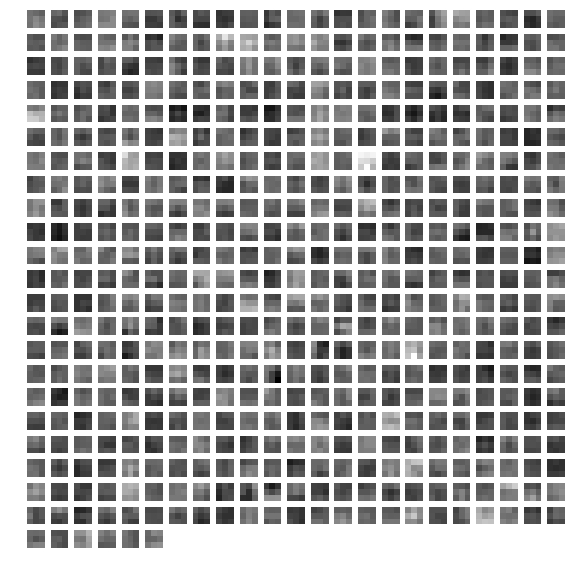

In [66]:
filters = net.params['conv5_3'][0].data
vis_square(filters[1])

data in the ROI Pooling layer, which is a patch in the conv1 feature map:

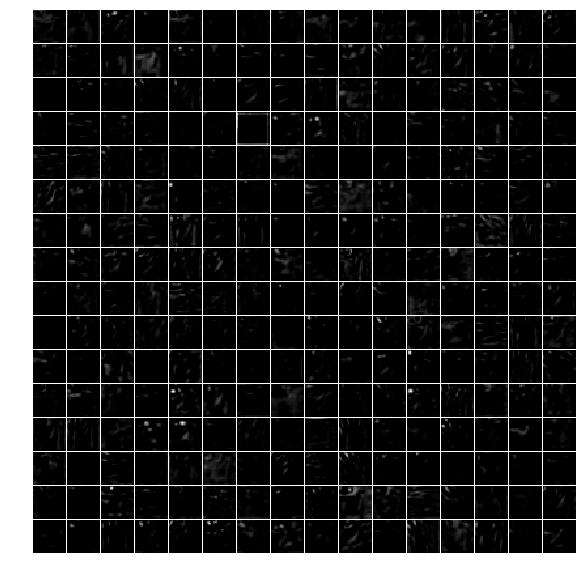

In [208]:
feat = net.blobs['conv3_3'].data[0]
vis_square(feat)

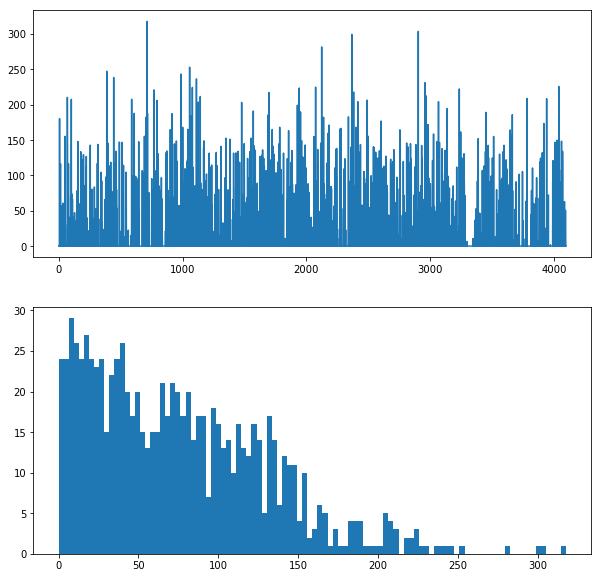

In [33]:
feat = net.blobs['regress_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

### Too slow! What should I do

In [19]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 163 ms per loop
